In [29]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the raw data

In [30]:
raw_data = pd.read_csv('data/de.csv')
raw_data.head()

,Polling Firm,Commissioners,Fieldwork Start,Fieldwork End,Scope,Sample Size,Sample Size Qualification,Participation,Precision,Union,SPD,Alternative für Deutschland,FDP,DIE LINKE,BÜNDNIS 90/DIE GRÜNEN,CDU,CSU,Piratenpartei Deutschland,Freie Wähler,Other
0,INSA and YouGov,NaN,2022-11-01,2022-11-04,National,1286,Provided,Not Available,1%,27%,21%,15%,8%,5%,17%,Not Available,Not Available,Not Available,Not Available,7%
1,Infratest dimap,NaN,2022-11-02,2022-11-02,National,1307,Provided,Not Available,1%,28%,19%,14%,6%,5%,19%,Not Available,Not Available,Not Available,Not Available,9%
2,Kantar,NaN,2022-11-02,2022-11-02,National,1516,Provided,Not Available,1%,26%,21%,14%,8%,5%,19%,Not Available,Not Available,Not Available,Not Available,7%
3,INSA and YouGov,NaN,2022-10-28,2022-10-31,National,2009,Provided,Not Available,0.5%,Not Available,20.5%,15%,9%,4.5%,18%,20%,6%,Not Available,Not Available,7%
4,Forsa,NaN,2022-10-25,2022-10-31,National,2503,Provided,77.0%,1%,27%,20%,14%,6%,4%,20%,Not Available,Not Available,Not Available,Not Available,9%


In [31]:
nb_polls = raw_data.shape[0]
print('Number of polls: {}'.format(nb_polls))

Number of polls: 3029


In [32]:
# Create a new column with the end data of the surveys
raw_data['date'] = pd.to_datetime(raw_data['Fieldwork End']).dt.to_period('M')

## Cleaning the dataframe 

In [33]:
# We need to clean the dataframe to only keep the date of each survey and parties we want
data = raw_data[['date', 'Sample Size', 'FDP', 'SPD', 'Union', 'Alternative für Deutschland', 'DIE LINKE', 'BÜNDNIS 90/DIE GRÜNEN']]

# Keep only surveys after january 2019
data = data[data['date'] >= '2019-01']

# Rename the columns
parties = ['FDP', 'SPD', 'CDU/CSU', 'AfD', 'LINKE', 'GRÜNE']
data.columns = ['date', 'Sample Size'] + parties

data.head()

,date,Sample Size,FDP,SPD,CDU/CSU,AfD,LINKE,GRÜNE
0,2022-11,1286,8%,21%,27%,15%,5%,17%
1,2022-11,1307,6%,19%,28%,14%,5%,19%
2,2022-11,1516,8%,21%,26%,14%,5%,19%
3,2022-10,2009,9%,20.5%,Not Available,15%,4.5%,18%
4,2022-10,2503,6%,20%,27%,14%,4%,20%


We still need to handle with the non available values and convert the percentages of parties into float between 0 to 1

In [34]:
# Convert values of Sample Size to numeric values except for 'Not Available'
data['Sample Size'] = pd.to_numeric(raw_data['Sample Size'], errors='coerce')

In [35]:
# In each row replace % by '' to convert to numeric values
for party in parties:
    data[party] = pd.to_numeric(data[party].replace('%', '', regex=True), errors='coerce') / 100


In [36]:
# Fill NaN values with the mean of each column
data[['Sample Size'] + parties] = data[['Sample Size'] + parties].fillna(data[['Sample Size'] + parties].mean())

In [37]:
# We end up with the following dataframe
data.head()

,date,Sample Size,FDP,SPD,CDU/CSU,AfD,LINKE,GRÜNE
0,2022-11,1286.0,0.08,0.210,0.270000,0.15,0.050,0.17
1,2022-11,1307.0,0.06,0.190,0.280000,0.14,0.050,0.19
2,2022-11,1516.0,0.08,0.210,0.260000,0.14,0.050,0.19
3,2022-10,2009.0,0.09,0.205,0.284537,0.15,0.045,0.18
4,2022-10,2503.0,0.06,0.200,0.270000,0.14,0.040,0.20


## Group the polls by month

Now we want to group each poll by month and compute the mean and the std according to the Sample Size in each group for each parties

In [39]:
# compute the mean of a party with respect to the sample size
def mean_coeff(party, sample_size):
    return sum(party * sample_size) / sum(sample_size)

In [40]:
# compute the standard deviation of a party with respect to the sample size
def std_coeff(col, sample_size):
    return (sum(sample_size * (col - mean_coeff(col, sample_size))**2) / sum(sample_size))**0.5

In [41]:
groups = data.groupby('date').apply(lambda x: pd.Series({
    'average_FDP': mean_coeff(x['FDP'], x['Sample Size']),
    'average_SPD': mean_coeff(x['SPD'], x['Sample Size']),
    'average_CDU/CSU': mean_coeff(x['CDU/CSU'], x['Sample Size']),
    'average_AfD': mean_coeff(x['AfD'], x['Sample Size']),
    'average_LINKE': mean_coeff(x['LINKE'], x['Sample Size']),
    'average_GRÜNE': mean_coeff(x['GRÜNE'], x['Sample Size']),
    'std_dev_FDP': std_coeff(x['FDP'], x['Sample Size']),
    'std_dev_SPD': std_coeff(x['SPD'], x['Sample Size']),
    'std_dev_CDU/CSU': std_coeff(x['CDU/CSU'], x['Sample Size']),
    'std_dev_AfD': std_coeff(x['AfD'], x['Sample Size']),
    'std_dev_LINKE': std_coeff(x['LINKE'], x['Sample Size']),
    'std_dev_GRÜNE': std_coeff(x['GRÜNE'], x['Sample Size']),
}))

## Ploting the popularity of parties during covid

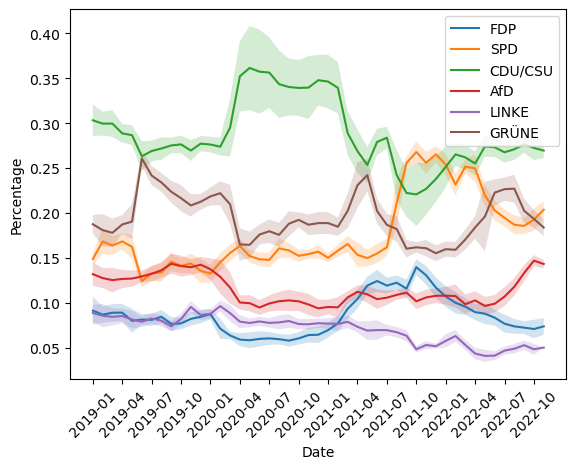

In [42]:
indexes = groups.index.map(lambda x: x.strftime('%Y-%m'))

for party in parties: 
    plt.fill_between(indexes, groups['average_' + party] - groups['std_dev_' + party], groups['average_' + party] + groups['std_dev_' + party], alpha=0.2)
    plt.plot(indexes, groups['average_' + party], label=party)

plt.xticks(range(0, len(indexes), 3), indexes[::3], rotation=45)
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
plt.show()